In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 데이터 뜯어보기

In [ ]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
df['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


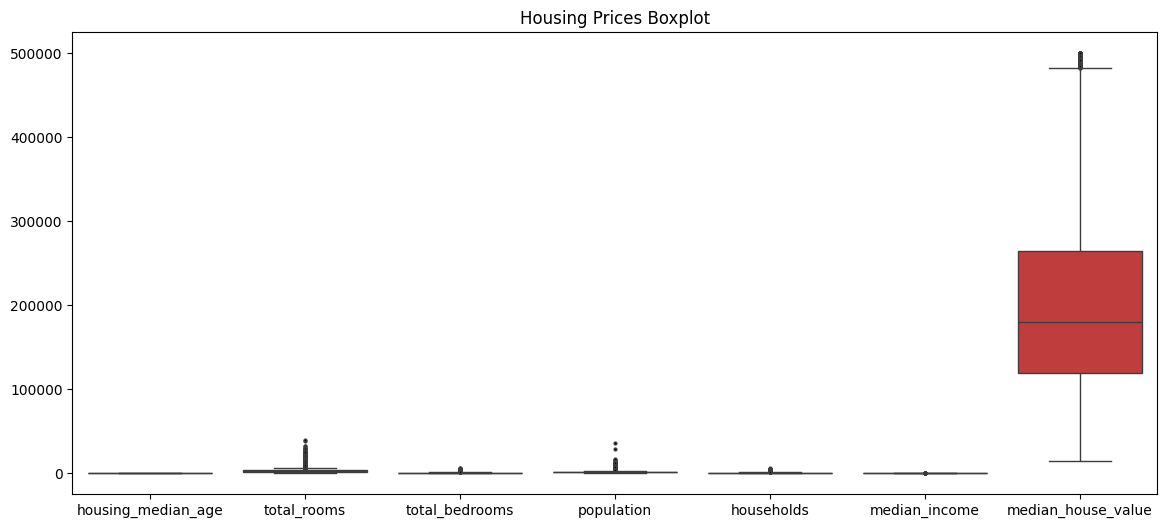

In [ ]:
plt.figure(figsize=(14, 6))
plt.title('Housing Prices Boxplot')
sns.boxplot(data = df[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']],
            palette='tab20', flierprops={'marker': '.', 'markersize': 4, 'markerfacecolor': 'black'})
plt.show()

# 이상치 확인

In [ ]:
df_tmp = df[['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]

q1 = df_tmp.quantile(0.25)
q3 = df_tmp.quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

mask = ((df_tmp >= lower_bound) & (df_tmp <= upper_bound)).all(axis=1)

df_clean = df[mask]
df_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [ ]:
# 3194개 행 삭제
df_clean.shape

(17446, 10)

# 결측치 확인

In [ ]:
df_clean.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


# 상관관계 확인

<Axes: xlabel='ocean_proximity'>

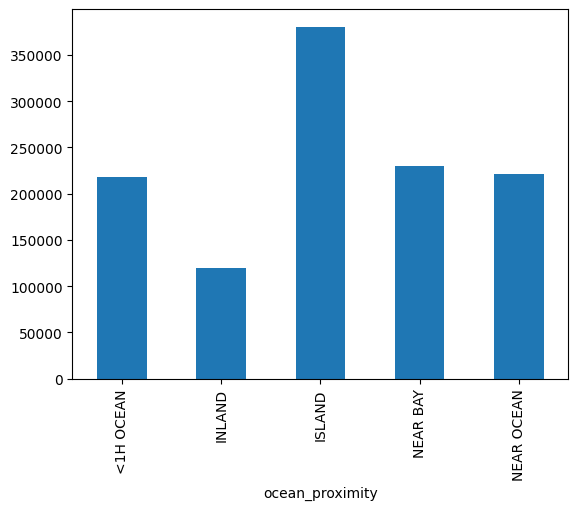

In [ ]:
# ISLAND일 때 높은 주택 가격
df_clean.groupby('ocean_proximity')['median_house_value'].mean().plot(kind='bar')

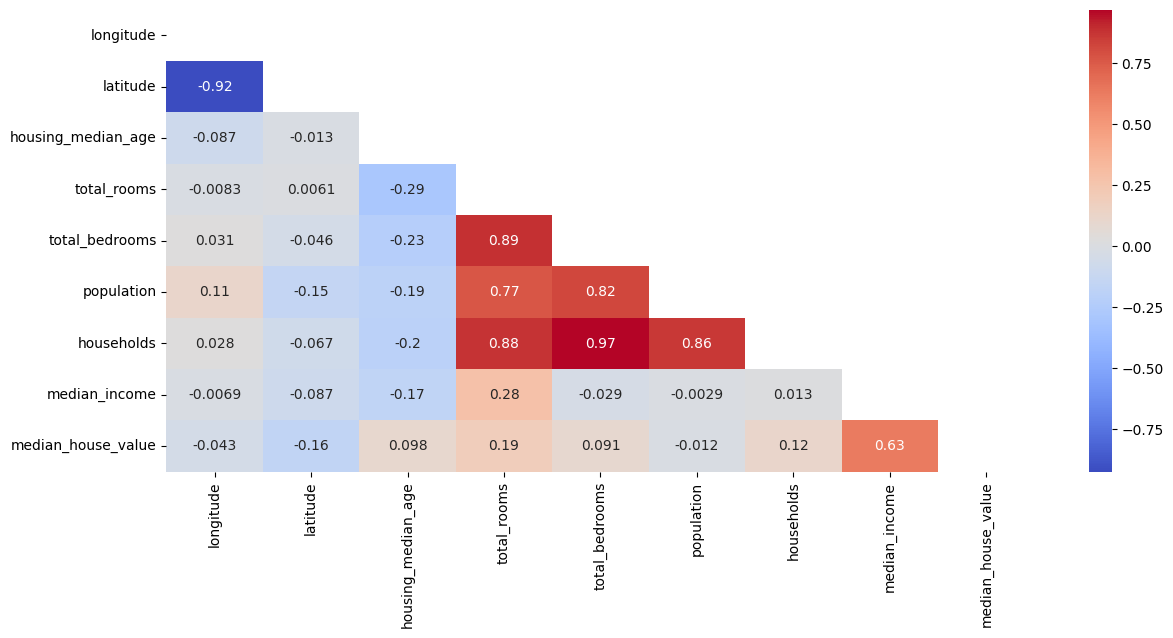

In [ ]:
# 상관계수가 높은 변수들이 발견되나 해당 데이터셋은 변수가 풍부하지 않아 제거하지 않음.

df_corr = df_clean[['longitude','latitude','housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']].corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(14, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', mask=mask)
plt.show()

# 데이터셋 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop('median_house_value', axis=1), df_clean['median_house_value'], random_state = 42, test_size = 0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13956, 9), (3490, 9), (13956,), (3490,))

# 스케일링

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, ['ocean_proximity']),
    ('num', numeric_transformer, ['longitude','latitude','housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])
], remainder = 'passthrough')

# 모델링

## 선형 회귀모델

In [ ]:
# LinearRegression
lin_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lin_regressor', LinearRegression())
])

# BayesianRidge
bay_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bay_regressor', BayesianRidge())
])

# Ridge
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge_regressor', Ridge())
])

# Lasso
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso_regressor', Lasso())
])

In [ ]:
param_grid_ridge = {
    'ridge_regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # 규제 강도 (0에 가까울수록 규제 약화)
}

param_grid_lasso = {
    'lasso_regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], # 규제 강도
    'lasso_regressor__max_iter': [1000, 2000, 5000],                # 최대 반복 횟수 (수렴 안될 때 늘려봄)
}

## ridge, lasso

In [ ]:
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

grid_search_cv_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring=scoring_metrics, refit='r2', n_jobs=-1)
grid_search_cv_lasso = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring=scoring_metrics, refit='r2', n_jobs=-1)

In [ ]:
grid_search_cv_ridge.fit(X_train, y_train)
grid_search_cv_lasso.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.907e+12, tolerance: 1.236e+10
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ocean_proximity']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income'])])),
                                       ('lasso_regressor', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso_regressor__alpha': [0.0001, 0.001, 0.01, 0.1,
                                                    1.0, 10.0],
                         'lasso_regressor__max_iter': [1000, 2000, 5000]},
             refit='r2',
             scoring=['neg_mean_squared_error', 'r2',
                      'neg_mean_absolute_error'])

In [ ]:
best_model_ridge = grid_search_cv_ridge.best_estimator_
best_model_lasso = grid_search_cv_lasso.best_estimator_

In [ ]:
ridge_pred = best_model_ridge.predict(X_test)
lasso_pred = best_model_lasso.predict(X_test)

### 결과 확인

In [ ]:
rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_pred))
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred))

r2_ridge = r2_score(y_test, ridge_pred)
r2_lasso = r2_score(y_test, lasso_pred)

mse_ridge = mean_squared_error(y_test, ridge_pred)
mse_lasso = mean_squared_error(y_test, lasso_pred)

In [ ]:
print("ridge RMSE: ", rmse_ridge)
print("ridge R2: ", r2_ridge)
print("ridge MSE: ", mse_ridge)
print("lasso RMSE: ", rmse_lasso)
print("lasso R2: ", r2_lasso)
print("lasso MSE: ", mse_lasso)

ridge RMSE:  57244.77768237574
ridge R2:  0.6150752283051446
ridge MSE:  3276964571.9046235
lasso RMSE:  57244.79841990906
lasso R2:  0.6150749494188585
lasso MSE:  3276966946.1360226


## linear regressor, bayesian regressor

In [ ]:
cross_val_lin_mse = cross_val_score(lin_pipeline, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)
cross_val_lin_mae = cross_val_score(lin_pipeline, X_train, y_train, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
cross_val_lin_r2 = cross_val_score(lin_pipeline, X_train, y_train, cv=5, scoring = 'r2', n_jobs=-1)

cross_val_bay_mse = cross_val_score(bay_pipeline, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)
cross_val_bay_mae = cross_val_score(bay_pipeline, X_train, y_train, cv=5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
cross_val_bay_r2 = cross_val_score(bay_pipeline, X_train, y_train, cv=5, scoring = 'r2', n_jobs=-1)

In [ ]:
# Linear Regression
results = {}
lin_rmse_scores = np.sqrt(-cross_val_lin_mse)
results['LinearRegression'] = {
    'RMSE_mean': lin_rmse_scores.mean(),
    'RMSE_std': lin_rmse_scores.std(),
    'MAE_mean': -cross_val_lin_mae.mean(), # MAE도 음수니까 다시 양수로
    'MAE_std': cross_val_lin_mae.std(),
    'R2_mean': cross_val_lin_r2.mean(),
    'R2_std': cross_val_lin_r2.std()
}

# Bayesian Ridge
bay_rmse_scores = np.sqrt(-cross_val_bay_mse)
results['BayesianRidge'] = {
    'RMSE_mean': bay_rmse_scores.mean(),
    'RMSE_std': bay_rmse_scores.std(),
    'MAE_mean': -cross_val_bay_mae.mean(),
    'MAE_std': cross_val_bay_mae.std(),
    'R2_mean': cross_val_bay_r2.mean(),
    'R2_std': cross_val_bay_r2.std()
}

### 결과 확인

In [ ]:
results['LinearRegression']

{'RMSE_mean': np.float64(57596.61610601378),
 'RMSE_std': np.float64(1353.4479121942468),
 'MAE_mean': np.float64(42902.7372892523),
 'MAE_std': np.float64(998.0676995133791),
 'R2_mean': np.float64(0.6252461298232561),
 'R2_std': np.float64(0.013004418589278827)}

In [ ]:
results['BayesianRidge']

{'RMSE_mean': np.float64(57617.523270658996),
 'RMSE_std': np.float64(1348.4388764069627),
 'MAE_mean': np.float64(42915.05026410961),
 'MAE_std': np.float64(989.4335018153927),
 'R2_mean': np.float64(0.6249698896080169),
 'R2_std': np.float64(0.01308857471136042)}

## RandomForestRegressor

In [ ]:
RF_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('RF', RandomForestRegressor(random_state = 42))
])

In [ ]:
param_grid_rf = {
    'RF__n_estimators': [100, 200, 300],
    'RF__max_depth': [None, 10, 20],
    'RF__min_samples_split': [2, 5, 10],
}

In [ ]:
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

In [ ]:
gridsearch_cv_rf = GridSearchCV(RF_pipeline, param_grid_rf, cv=5, scoring=scoring_metrics, refit='r2', n_jobs=-1)

In [ ]:
gridsearch_cv_rf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ocean_proximity']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income'])])),
                                       ('RF',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'RF__max_depth': [None, 10, 20],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [100, 200, 300]},
             refit='r2',
             scoring=['accuracy', 'neg_mean_squared_error', 'r2',
                      'neg_mean_absolute_error'])

In [ ]:
best_model_rf = gridsearch_cv_rf.best_estimator_

### 결과 확인

In [ ]:
rf_pred = best_model_rf.predict(X_test)

In [ ]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("R2: ", r2_score(y_test, rf_pred))
print("MAE: ", mean_absolute_error(y_test, rf_pred))

RMSE:  42991.25293954086
R2:  0.7828977524405233
MAE:  28929.852305635148


## XGBoost

In [ ]:
XGB_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGB', XGBRegressor(random_state=42))
])

In [ ]:
param_grid_xgb = {
    'XGB__n_estimators': [100, 200, 300],
    'XGB__max_depth': [3, 4, 5],
    'XGB__learning_rate': [0.01, 0.03, 0.05],
    'XGB__subsample': [0.6, 0.7, 0.8]
}

In [ ]:
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']

In [ ]:
Gridsearch_cv_xgb = GridSearchCV(XGB_pipeline, param_grid_xgb, cv=5, scoring = scoring_metrics, refit='r2', n_jobs=-1)

In [ ]:
Gridsearch_cv_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ocean_proximity']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'populati...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'XGB__learning_rate': [0.01, 0.03, 0.05],
                         'XGB__max_depth': [3, 4, 5],
                         'XGB__n_estimators': [100, 200, 300],
                         'XGB__subsample': [0.6, 0.7, 0.8]},
             refit='r2',
             scoring=['neg_mean_squared_error', 'r2',
                      'neg_mean_absolute_error'])

In [ ]:
best_model_xgb = Gridsearch_cv_xgb.best_estimator_

In [ ]:
xgb_pred = best_model_xgb.predict(X_test)

In [ ]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("R2: ", r2_score(y_test, xgb_pred))
print("MAE: ", mean_absolute_error(y_test, xgb_pred))

RMSE:  42760.564206262825
R2:  0.785221419122476
MAE:  29162.351856867837
